# Set up

In [3]:
#Basics
import pandas as pd
from pandas import DataFrame
import numpy as np

from datetime import datetime, timedelta

#Visuals
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn import cross_decomposition
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor


from sklearn.metrics import mean_absolute_error, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, chi2, VarianceThreshold

import xgboost as xgb


# Default figure size
sns.set(rc={"figure.figsize": (12, 6)})

# Hoping to get rid of these
from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

rand_seed = 1234

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My Drive/Thesis/Thesissub

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Thesis/Thesissub


In [5]:
df = pd.read_csv('cleaned_BTC.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


## Datetime conversion
df['date'] = pd.to_datetime(df.date)

# Setting the index
df = df.set_index('date')

df.head()

df = df.tail(750)


# Models 
*  Linear Regression
*  Bayesian Ridge
*  ElasticNetCV
*  Random Forest Regressor
*  XgBoost regresion
*  Neural Network with RELU 


## Build Pipelines

In [6]:
model_name = ("Linear regression", "Bayesian Ridge", "Elastic Net CV", "Random Forest", "Xgboost regression",  "NN regression")

In [7]:
rand_seed =123

print("Building simple models..")

linear = LinearRegression()
bayesRidge = BayesianRidge()
enet = ElasticNetCV(random_state=rand_seed)
rf = RandomForestRegressor(n_estimators=500, random_state=rand_seed)
xgReg = xgb.XGBRegressor(seed=rand_seed, objective ='reg:squarederror')
NN = MLPRegressor(solver = 'adam', hidden_layer_sizes=(8,8,8), activation='relu', max_iter=500)

print("Building pipelines..")

linear_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(linear)),
    ('reg', linear)
])

bayes_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(bayesRidge)),
    ('reg', bayesRidge)
])

enet_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(enet)),
    ('reg', enet)
])

rf_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(rf)),
    ('reg', rf)
])

xgb_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('reg', xgReg)
])

NN_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(rf)),
    ('reg', NN)  
])

print("Done!")

Building simple models..
Building pipelines..
Done!


## Bitcoin

### Models - BTC - next day

In [8]:
btc = df

future_predict = 1
btc['future'] = btc['close'].shift(-future_predict)

btc.head()

btc = btc.dropna()

In [9]:
X = btc.drop(['future'], axis=1)
y = btc['future']

BTC_X_train, BTC_X_test, BTC_y_train, BTC_y_test = train_test_split(X, y, train_size=0.7, shuffle=False )

In [10]:
btc = df

future_predict = 1
btc['future'] = btc['close'].shift(-future_predict)



btc = btc.dropna()
btc = btc.reset_index()
btc = btc.drop(['date'], axis=1)
X = btc.drop(['future'], axis=1)
y = btc['future']

BTC_X_train, BTC_X_test, BTC_y_train, BTC_y_test = train_test_split(X, y, train_size=0.7, shuffle=False )


In [11]:
BTC_y_test

521     8807.010742
522     8723.786133
523     8929.038086
524     8942.808594
525     8706.245117
           ...     
740    11681.825195
741    11664.847656
742    11774.595703
743    11366.134766
744    11488.363281
Name: future, Length: 224, dtype: float64

In [12]:
BTC_y_test.to_csv('BTC_y_test_5.csv')

# Test Train split

In [36]:
from sklearn.metrics import mean_squared_error, r2_score


In [40]:
mean_squared_error

<function sklearn.metrics._regression.mean_squared_error>

In [46]:
models = [linear_pipe, bayes_pipe, enet_pipe, rf_pipe, xgb_pipe, NN_pipeline]
model_dict = {0: "Linear regression", 1: "Bayesian Ridge", 2: "Elastic Net CV", 
              3: "Random Forest", 4: "Xgboost regression", 5: "NN regression"}

model_mae = []
model_mse = []
model_rmse = []
model_score = []
res_dict = {}

for i, model in enumerate(models):
    
    model.fit(BTC_X_train, BTC_y_train)
    preds = model.predict(BTC_X_test)
   
    res_dict[i] = preds
    
    mae_res = mean_absolute_error(BTC_y_test, preds)
    mse_res = mean_squared_error(BTC_y_test, preds)
    rmse_res = mean_squared_error(BTC_y_test, preds,squared=False)
    score = model.score(BTC_X_test, BTC_y_test)

    print("MAE for %s =%s" % (model_dict[i], mae_res))
    print("MSE for %s =%s" % (model_dict[i], mse_res))
    print("RMSE for %s =%s" % (model_dict[i], rmse_res))
    print("Score for %s =%s" % (model_dict[i], score))
    
    model_mae.append(mae_res)
    model_mse.append(mse_res)
    model_rmse.append(rmse_res)
    model_score.append(score)



MAE for Linear regression =61.09597664099051
MSE for Linear regression =6507.821766375574
RMSE for Linear regression =80.67107143440934
Score for Linear regression =-0.6274536137097073
MAE for Bayesian Ridge =63.518490016899825
MSE for Bayesian Ridge =7645.296664862258
RMSE for Bayesian Ridge =87.43738711136248
Score for Bayesian Ridge =-0.9119094117481386
MAE for Elastic Net CV =48.91039174540337
MSE for Elastic Net CV =4620.159900933419
RMSE for Elastic Net CV =67.97175811271487
Score for Elastic Net CV =-0.1553936473091848
MAE for Random Forest =61.495930394412454
MSE for Random Forest =6208.619148088973
RMSE for Random Forest =78.79479137664477
Score for Random Forest =-0.5526300552530463
MAE for Xgboost regression =61.648696401526514
MSE for Xgboost regression =6234.015107665742
RMSE for Xgboost regression =78.9557794443557
Score for Xgboost regression =-0.5589809892015425
MAE for NN regression =67.56664780202912
MSE for NN regression =7424.861683823307
RMSE for NN regression =86.

### Results

In [47]:
actual = BTC_y_test.values

In [15]:
b= {'Test': model_name, 'BTC_MAE':model_mae, 'BTC_MSE':model_mse,'BTC_RMSE':model_rmse,'BTC_Score': model_score}
BTC_results = pd.DataFrame(b)
BTC_results
BTC_results.sort_values(by=['BTC_Score'], ascending=False)

,Test,BTC_MAE,BTC_MSE,BTC_RMSE,BTC_Score
4,Xgboost regression,687.159585,8.646365e+05,929.858346,0.643399
3,Random Forest,719.962980,8.705107e+05,933.011640,0.640976
0,Linear regression,721.866621,9.043070e+05,950.950576,0.627037
1,Bayesian Ridge,725.686803,9.185932e+05,958.432673,0.621145
2,Elastic Net CV,1106.413365,1.740615e+06,1319.323869,0.282119
5,NN regression,2908.541718,1.250064e+07,3535.625096,-4.155632


In [16]:
BTC_results.to_csv('ML_models_30day.csv')

## save predict

In [48]:
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= actual))    

In [18]:
res_df.to_csv('model prediction5.csv')

In [44]:
actual = BTC_y_test.values

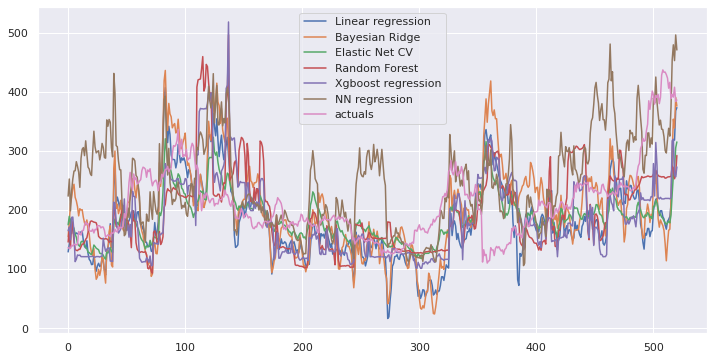

In [52]:
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= actual))    

res_df.plot()

fig.suptitle("Results");

# Run for ETH

# Models - BTC - next day

In [53]:
eth = pd.read_csv('cleaned_BTC.csv')
eth = eth.loc[:, ~eth.columns.str.contains('^Unnamed')]

In [54]:
btc = eth

future_predict = 5
btc['future'] = btc['close'].shift(-future_predict)


btc = btc.dropna()
btc = btc.drop(['date'], axis=1)
X = btc.drop(['future'], axis=1)
y = btc['future']

BTC_X_train, BTC_X_test, BTC_y_train,BTC_y_test = train_test_split(X, y, train_size=0.7, shuffle=False )


In [55]:
from sklearn.metrics import mean_squared_error

In [56]:
models = [linear_pipe, bayes_pipe, enet_pipe, rf_pipe, xgb_pipe, NN_pipeline]
model_dict = {0: "Linear regression", 1: "Bayesian Ridge", 2: "Elastic Net CV", 
              3: "Random Forest", 4: "Xgboost regression", 5: "NN regression"}

model_mae = []
model_mse = []
model_rmse = []
model_score = []
res_dict = {}

for i, model in enumerate(models):
    
    model.fit(BTC_X_train, BTC_y_train)
    preds = model.predict(BTC_X_test)
   
    res_dict[i] = preds
    
    mae_res = mean_absolute_error(BTC_y_test, preds)
    mse_res = mean_squared_error(BTC_y_test, preds)
    rmse_res = mean_squared_error(BTC_y_test, preds,squared=False)
    score = model.score(BTC_X_test, BTC_y_test)

    print("MAE for %s =%s" % (model_dict[i], mae_res))
    print("MSE for %s =%s" % (model_dict[i], mse_res))
    print("RMSE for %s =%s" % (model_dict[i], rmse_res))
    print("Score for %s =%s" % (model_dict[i], score))
    
    model_mae.append(mae_res)
    model_mse.append(mse_res)
    model_rmse.append(rmse_res)
    model_score.append(score)



MAE for Linear regression =646.9160595518169
MSE for Linear regression =781491.9020290227
RMSE for Linear regression =884.0203063442732
Score for Linear regression =0.7818122938921255
MAE for Bayesian Ridge =645.494016705707
MSE for Bayesian Ridge =731565.5858968734
RMSE for Bayesian Ridge =855.3160736808782
Score for Bayesian Ridge =0.7957514125995714
MAE for Elastic Net CV =4068.1172320921537
MSE for Elastic Net CV =18938079.605769575
RMSE for Elastic Net CV =4351.790390835658
Score for Elastic Net CV =-4.287394708176683
MAE for Random Forest =1129.5562830579354
MSE for Random Forest =2373214.0118435514
RMSE for Random Forest =1540.523940691462
Score for Random Forest =0.33741332443393557
MAE for Xgboost regression =1093.2369181315105
MSE for Xgboost regression =2184723.902376858
RMSE for Xgboost regression =1478.08115554487
Score for Xgboost regression =0.39003859732771995
MAE for NN regression =655.1199279012054
MSE for NN regression =765982.5670582195
RMSE for NN regression =875.2

In [24]:
b= {'Test': model_name, 'BTC_MAE':model_mae, 'BTC_MSE':model_mse,'BTC_RMSE':model_rmse,'BTC_Score': model_score}
BTC_results = pd.DataFrame(b)
BTC_results
BTC_results.sort_values(by=['BTC_Score'], ascending=False)

,Test,BTC_MAE,BTC_MSE,BTC_RMSE,BTC_Score
4,Xgboost regression,20.287459,709.258898,26.631915,0.823175
1,Bayesian Ridge,23.787639,915.220177,30.252606,0.771827
5,NN regression,25.686273,1164.341433,34.122448,0.709719
2,Elastic Net CV,25.733309,1180.251403,34.354787,0.705753
0,Linear regression,27.928626,1224.898851,34.998555,0.694622
3,Random Forest,35.719005,1896.592514,43.549885,0.527163


In [25]:
BTC_results.to_csv('ML_models__ETH_5day.csv')

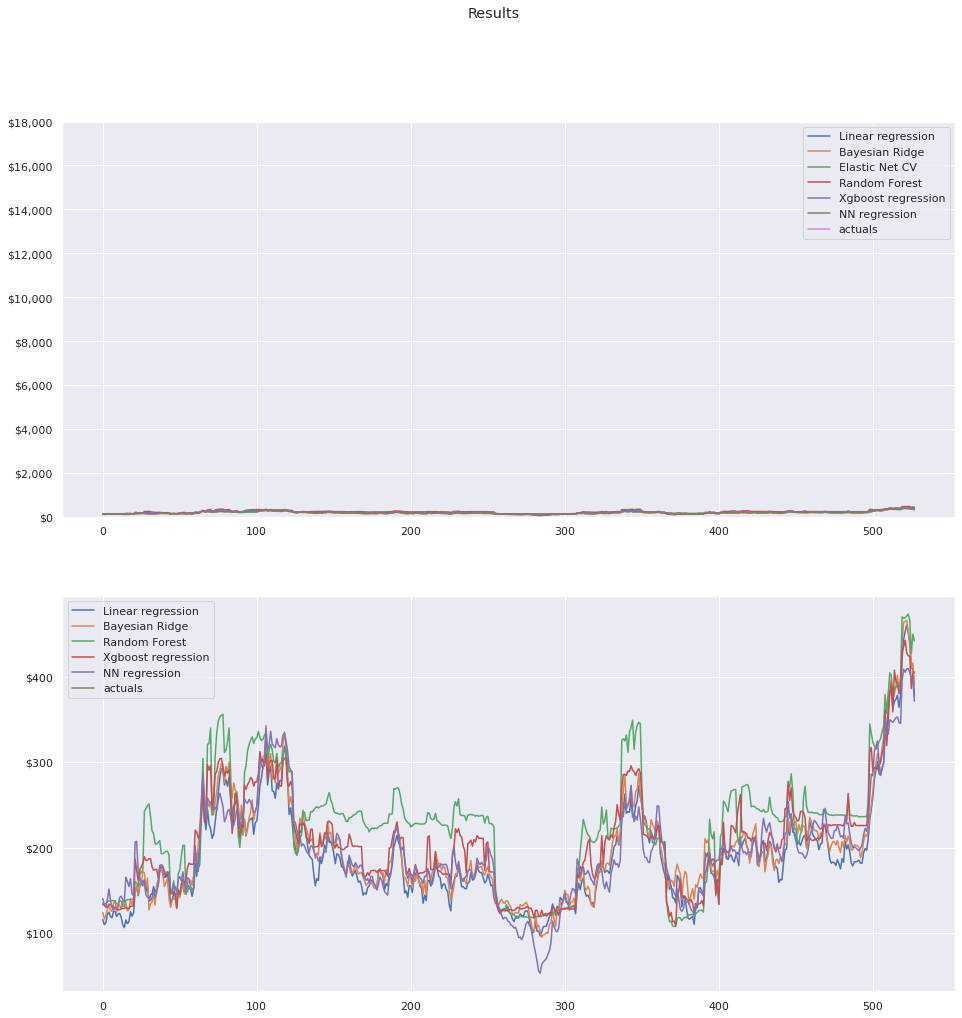

In [26]:
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= BTC_y_test))    

fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, figsize=(16, 16))

res_df.plot(ax=ax0)
ax0.get_yaxis().set_major_formatter(tick)
ax0.set_ylim(0, 18000)
 
res_df.drop("Elastic Net CV", axis=1).plot(ax=ax1)

ax1.get_yaxis().set_major_formatter(tick)
fig.suptitle("Results");

# ETH 30








In [27]:
eth = pd.read_csv('cleaned_ETH.csv')
eth = eth.loc[:, ~eth.columns.str.contains('^Unnamed')]

In [28]:
btc = eth

future_predict = 30
btc['future'] = btc['close'].shift(-future_predict)


btc = btc.dropna()
btc = btc.drop(['date'], axis=1)
X = btc.drop(['future'], axis=1)
y = btc['future']

BTC_X_train, BTC_X_test, BTC_y_train,BTC_y_test = train_test_split(X, y, train_size=0.7, shuffle=False )


In [29]:
y

0         0.884183
1         0.867951
2         0.915703
3         0.878614
4         0.873119
           ...    
1730    395.835144
1731    391.384491
1732    408.144196
1733    384.001038
1734    386.466125
Name: future, Length: 1735, dtype: float64

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
models = [linear_pipe, bayes_pipe, enet_pipe, rf_pipe, xgb_pipe, NN_pipeline]
model_dict = {0: "Linear regression", 1: "Bayesian Ridge", 2: "Elastic Net CV", 
              3: "Random Forest", 4: "Xgboost regression", 5: "NN regression"}

model_mae = []
model_mse = []
model_rmse = []
model_score = []
res_dict = {}

for i, model in enumerate(models):
    
    model.fit(BTC_X_train, BTC_y_train)
    preds = model.predict(BTC_X_test)
   
    res_dict[i] = preds
    
    mae_res = mean_absolute_error(BTC_y_test, preds)
    mse_res = mean_squared_error(BTC_y_test, preds)
    rmse_res = mean_squared_error(BTC_y_test, preds,squared=False)
    score = model.score(BTC_X_test, BTC_y_test)

    print("MAE for %s =%s" % (model_dict[i], mae_res))
    print("MSE for %s =%s" % (model_dict[i], mse_res))
    print("RMSE for %s =%s" % (model_dict[i], rmse_res))
    print("Score for %s =%s" % (model_dict[i], score))
    
    model_mae.append(mae_res)
    model_mse.append(mse_res)
    model_rmse.append(rmse_res)
    model_score.append(score)



MAE for Linear regression =61.09597664099051
MSE for Linear regression =6507.821766375574
RMSE for Linear regression =80.67107143440934
Score for Linear regression =-0.6274536137097073
MAE for Bayesian Ridge =63.518490016899825
MSE for Bayesian Ridge =7645.296664862258
RMSE for Bayesian Ridge =87.43738711136248
Score for Bayesian Ridge =-0.9119094117481386
MAE for Elastic Net CV =48.91039174540337
MSE for Elastic Net CV =4620.159900933419
RMSE for Elastic Net CV =67.97175811271487
Score for Elastic Net CV =-0.1553936473091848
MAE for Random Forest =61.495930394412454
MSE for Random Forest =6208.619148088973
RMSE for Random Forest =78.79479137664477
Score for Random Forest =-0.5526300552530463
MAE for Xgboost regression =61.648696401526514
MSE for Xgboost regression =6234.015107665742
RMSE for Xgboost regression =78.9557794443557
Score for Xgboost regression =-0.5589809892015425
MAE for NN regression =60.16787685074849
MSE for NN regression =6717.089960934203
RMSE for NN regression =81.

In [32]:
b= {'Test': model_name, 'BTC_MAE':model_mae, 'BTC_MSE':model_mse,'BTC_RMSE':model_rmse,'BTC_Score': model_score}
BTC_results = pd.DataFrame(b)
BTC_results
BTC_results.sort_values(by=['BTC_Score'], ascending=False)

,Test,BTC_MAE,BTC_MSE,BTC_RMSE,BTC_Score
2,Elastic Net CV,48.910392,4620.159901,67.971758,-0.155394
3,Random Forest,61.495930,6208.619148,78.794791,-0.552630
4,Xgboost regression,61.648696,6234.015108,78.955779,-0.558981
0,Linear regression,61.095977,6507.821766,80.671071,-0.627454
5,NN regression,60.167877,6717.089961,81.957855,-0.679787
1,Bayesian Ridge,63.518490,7645.296665,87.437387,-0.911909


In [33]:
BTC_results.to_csv('ML_models__ETH_30day.csv')

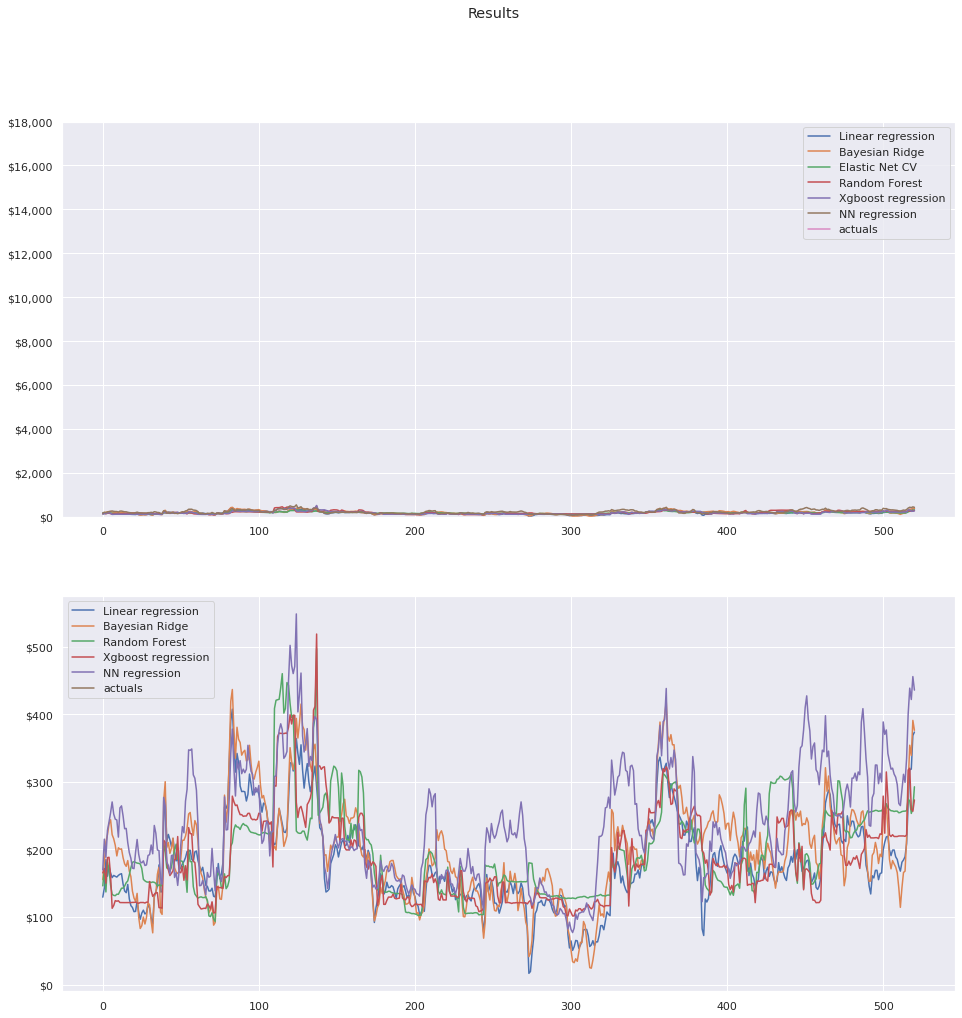

In [34]:
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= BTC_y_test))    

fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, figsize=(16, 16))

res_df.plot(ax=ax0)
ax0.get_yaxis().set_major_formatter(tick)
ax0.set_ylim(0, 18000)
 
res_df.drop("Elastic Net CV", axis=1).plot(ax=ax1)

ax1.get_yaxis().set_major_formatter(tick)
fig.suptitle("Results");